In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)
# reflect the tables


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement=Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [17]:
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01',)

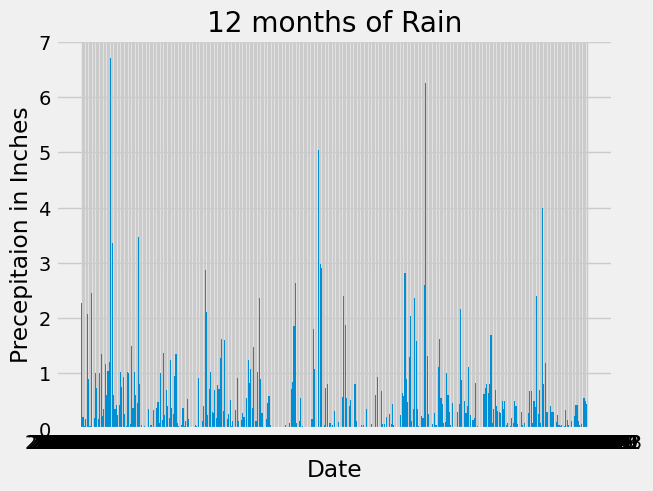

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date = session.query(measurement.date).order_by(measurement.date.desc()).first()
start_date=list(np.ravel(date))[0]
last_date=dt.datetime.strptime(start_date,"%Y-%m-%d")
year=last_date-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data=session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).\
filter(measurement.date>=year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df=pd.DataFrame(data)


# Sort the dataframe by date
df.sort_values(by=['date'], ascending=True)
df=df.dropna()


# Use Pandas Plotting with Matplotlib to plot the data
x=df['date']
y=df['prcp']
plt.bar(x,y)
plt.title("12 months of Rain")
plt.xlabel("Date")
plt.ylabel("Precepitaion in Inches")
plt.show()


In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
count_stations = session.query(station).\
    distinct().\
    count()
count_stations

9

In [83]:
station_measurment=session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_measurment

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(measurement,
                               measurement.station,
                               station.name, 
                               func.count(measurement.station).label('station_count')).\
                    join(station, measurement.station==station.station).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).\
                    all()
for row in active_station:
    print(f"{row.station} observations were made at {row.name}")


USC00519281 observations were made at WAIHEE 837.5, HI US
USC00519397 observations were made at WAIKIKI 717.2, HI US
USC00513117 observations were made at KANEOHE 838.1, HI US
USC00519523 observations were made at WAIMANALO EXPERIMENTAL FARM, HI US
USC00516128 observations were made at MANOA LYON ARBO 785.2, HI US
USC00514830 observations were made at KUALOA RANCH HEADQUARTERS 886.9, HI US
USC00511918 observations were made at HONOLULU OBSERVATORY 702.2, HI US
USC00517948 observations were made at PEARL CITY, HI US
USC00518838 observations were made at UPPER WAHIAWA 874.3, HI US


In [66]:
top_station = session.query(measurement,
                               measurement.station,
                               station.name, 
                               func.count(measurement.station).label('station_count')).\
                    join(station, measurement.station==station.station).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).\
                    first()
print(f"{top_station.name} had the most observations at {top_station.station_count}")

WAIHEE 837.5, HI US had the most observations at 2772


In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = session.query(measurement.station).\
                group_by(measurement.station).\
                order_by(func.count(measurement.station).desc()).\
                first()
t_station = top_station.station


top_station_stats = session.query(measurement, 
                                  func.max(measurement.tobs).label('max_temp'),
                                  func.min(measurement.tobs).label('min_temp'),
                                  func.avg(measurement.tobs).label('avg_temp'),
                                  station.name.label('sta_name')).\
                    join(station, measurement.station==station.station).\
                    filter(measurement.station == t_station).\
                    first()
print(f'{top_station_stats.max_temp} max temp')
print(f'{top_station_stats.min_temp} min temp')
print(f'{top_station_stats.avg_temp} average temp')

85.0 max temp
54.0 min temp
71.66378066378067 average temp


In [87]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=session.query(measurement.date).order_by(measurement.date.desc()).\
             filter(measurement.station==station_measurment[0][0]).first()
str_date=list(np.ravel(results))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(measurement.tobs).\
             filter(measurement.station==station_measurment[0][0]).\
             filter(measurement.date>=year_back).all()
df=pd.DataFrame(results_temp)



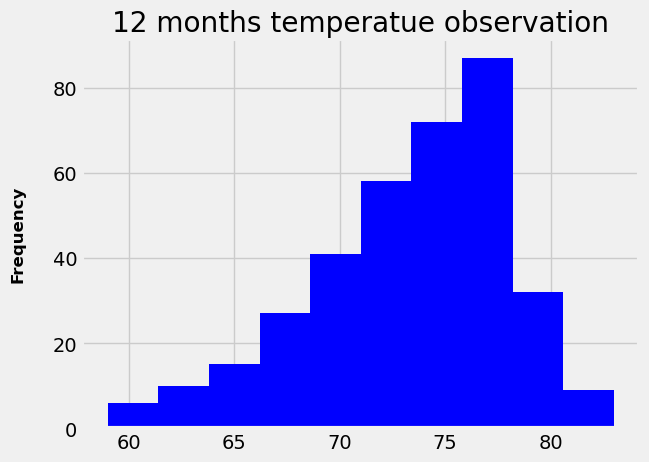

In [90]:
# histogram
hist = df['tobs'].hist(color='b')

# Remove title
hist.set_title("12 months temperatue observation")

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

# Close Session

In [91]:
# Close Session
session.close()